In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import io
from scipy import spatial

In [ ]:
f = open("text8", "r")
x = f.read()
f.close()

In [ ]:
tokens = np.array(x.split())
del x

In [ ]:
from collections import Counter

count = Counter(tokens)
vocab, index = {}, 1 # start indexing from 1
vocab[0] = "<UNK>"
for token in sorted(count, key = count.get, reverse = True):
  if token not in vocab: 
    vocab[token] = index
    index += 1
  if index > 30000:
    break
vocab_size = len(vocab)
print(vocab_size)

30001


In [ ]:
inverse_vocab = {index: token for token, index in vocab.items()}

In [ ]:
example = 'this is the worst'.split()
example_sequence = [vocab[word] for word in example]
print(example_sequence)

[33, 11, 1, 3680]


In [ ]:
def generate_training_data(tokens, window_size, vocab_size, batch_size):
  target_batch = np.zeros(batch_size)
  context_batch = np.zeros(shape = (batch_size, 1, vocab_size))
  batch_pointer = 0
  while True:  
    for i in range(0,len(tokens)):
      k = i - window_size
      while k <= i + window_size:
        if k < 0 or k >= len(tokens) or k == i:
          k+=1
          continue
        context = np.zeros(vocab_size)
        if tokens[k] in vocab:
          context[vocab[tokens[k]]] = 1
        else:
          context[0] = 1
        if tokens[i] in vocab:
          target_batch[batch_pointer] = vocab[tokens[i]]
        else:
          target_batch[batch_pointer] = 0
        context_batch[batch_pointer] = context
        batch_pointer+=1
        k+=1
        if batch_pointer == batch_size:
          batch_pointer = 0
          # print(target_batch.shape)
          # print(context_batch.shape)
          yield target_batch,context_batch

In [ ]:
x = generate_training_data(tokens, 2, vocab_size, 1024)

In [ ]:
sample =next(x)
print(sample[0], np.argmax(sample[1], axis=1))

(1024,)
(1024, 1, 30001)
[5234. 5234. 3081. ... 4188. 4188. 4188.] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
embedding_dim = 500
bsize = 2000
model = tf.keras.Sequential()

In [ ]:
model.add(tf.keras.layers.Input(shape=(1),dtype='int32'))

In [ ]:
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=1,name="w2v_embedding"))

In [ ]:
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', use_bias=False))

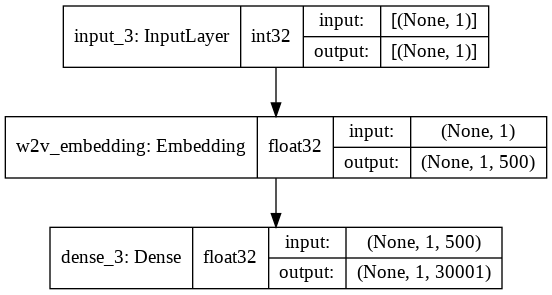

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True,show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
def scheduler(epoch, lr):
  return (epoch * -0.000001944990176817289 + 0.001)

In [ ]:
lsch = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
model.fit(generate_training_data(tokens, 2, vocab_size, bsize), steps_per_epoch=1000, epochs=50, batch_size = bsize, callbacks=[lsch])

In [ ]:
weights = model.get_layer('w2v_embedding').get_weights()[0]

In [ ]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if  index == 0: continue # skip 0, it's padding.
  vec = weights[index] 
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception as e:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new = weights[vocab['sings']]-weights[vocab['sing']]+weights[vocab['provide']]

In [ ]:
top = {}
for i in range(len(weights)):
  top[i] = 1 - spatial.distance.cosine(new, weights[i])

In [ ]:
top = sorted(top, key = top.get,reverse=True)

In [ ]:
[inverse_vocab[i] for i in top[:25]]

['provide',
 'provides',
 'provided',
 'offer',
 'supplementary',
 'require',
 'providing',
 'offers',
 'generating',
 'generate',
 'necessitating',
 'regulates',
 'connectivity',
 'identifier',
 'implement',
 'allow',
 'utilizing',
 'maintains',
 'requires',
 'implementing',
 'modelling',
 'framework',
 'enables',
 'supports',
 'permits']

In [ ]:
vocab['kathmandu']

18961